# VHM python implemented model structure

## Import libraries and set image properties

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import LinearLocator
sns.set_style('whitegrid')

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14 

In [4]:
from VHM import VHM_flexible

In [5]:
import brewer2mpl
setblue = brewer2mpl.get_map('Greys', 'Sequential', 6,
                             reverse = True).mpl_colors

## Load observations

In [6]:
data = pd.read_csv("/media/DATA/Githubs/project_breach_pdm_application/data/data_brach_case_nete.csv", 
                   parse_dates=True, index_col=0)

In [7]:
data.head()

,rain,evapotranspiration,meas,p5,p95
2002-01-01 00:00:00,0,0,NaN,NaN,NaN
2002-01-01 01:00:00,0,0,NaN,NaN,NaN
2002-01-01 02:00:00,0,0,NaN,NaN,NaN
2002-01-01 03:00:00,0,0,NaN,NaN,NaN
2002-01-01 04:00:00,0,0,NaN,NaN,NaN


## Model simulation

###  Parameter values, initial conditions and constant values

In [8]:
# Parameters
umax =280.0
uevap = 150.0
c1s = 1.8
c2s = 0.4
c3s = 1.0
c1o = -3.9
c2o = 1.59
c3o = 0.0
c4o = 0.0
c1i = -2.7
c2i = 1.
c3i = 0.0
c4i = 0.0
nso = 50
nsi = 50
Kg = 2400.0
Ki =120.0
Ko =10.0

# Define the constants
area = 361.
timestep = 1.

# Define the initial conditions
u = 170.0
qg =1.0
cg =0.0
qo =0.0
co =0.0
qi =1.0
ci =0.0

In [9]:
pars = [umax,uevap,c1s,c2s,c3s,c1o,c2o,c3o,c4o,c1i,c2i,c3i,c4i,nso,nsi,Kg,Ki,Ko]
constants = [area,timestep]
init_conditions = [u, qg, cg, qo, co, qi, ci]

### Structural options

* fracthand 'relative' or 'sequentialx' with x [1-4]
* storhand 'linear' or 'nonlinear'
* interflowhand True or False
* infexcesshand True or False
* nres_g/nres_i/nres_o string of 3 options, each [1-2], eg 211, 121,...

In [10]:
structure_options=['relative', 'nonlinear', True, True, '211']

### Run the model

In [11]:
rain = data['rain'].values
pet = data['evapotranspiration'].values

In [12]:
vhm_output = VHM_flexible(pars, constants, init_conditions,
                    structure_options, rain, pet)

In [13]:
outflows, fractions, moisture = vhm_output

In [14]:
# create dataframe with 
data['modtot'] = outflows[:, 0]
data['modover'] = outflows[:, 1]
data['modinter'] = outflows[:, 2]
data['modbase'] = outflows[:, 3]
data['fracover'] = fractions[:, 0]
data['fracinter'] = fractions[:, 1]
data['fracbase'] = fractions[:, 2]
data['fracsoil'] = fractions[:, 3]
data['fractotal'] = data['fracover'] + data['fracinter'] + data['fracbase'] + data['fracsoil']
data['soil'] = moisture

**Focus on a subperiod to plot**

In [15]:
data2plot = data['2003':'2005']

### Plot the model output and observations to evaluate the fit

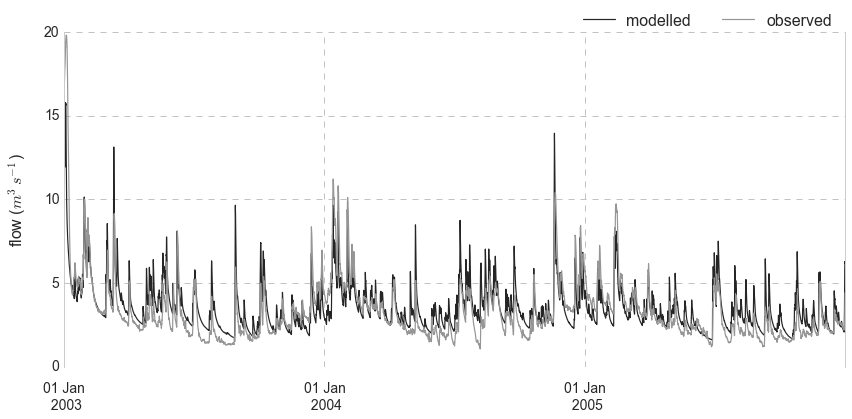

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(14, 6), sharex=True)

axs.plot(data2plot.index, data2plot['modtot'], label='modelled')
axs.plot(data2plot.index, data2plot['meas'], label='observed')

axs.set_ylabel("flow ($m^3s^{-1}$)")
axs.yaxis.labelpad = 15

axs.xaxis.set_major_locator(
                mpl.dates.MonthLocator(interval = 12))
axs.xaxis.set_major_formatter(
                mpl.dates.DateFormatter('%d %b \n %Y'))
axs.tick_params(axis = 'x', pad = 15, direction='out')

# y-axis
axs.tick_params(axis = 'y', pad = 5, direction='out')

#remove spines
axs.spines['bottom'].set_visible(False)
axs.spines['top'].set_visible(False)
# set grid
axs.grid(which='both', axis='both', color='0.7',
             linestyle='--', linewidth=0.8)
# line colors of the plots
axs.lines[0].set_color(setblue[0])
axs.lines[1].set_color(setblue[2])

# line widths
for line in axs.lines:
    line.set_linewidth(1.2)

axs.legend(loc='upper right', fontsize=16, ncol=2, bbox_to_anchor=(1., 1.1))    

#plt.savefig('vhm_flow_example.pdf', dpi=300)
#plt.savefig('vhm_flow_example.png', dpi=300)

### Plot modelled and filtered subflows in function of time

In [19]:
overf = pd.read_csv("Filter_Overlandflow3.txt", index_col=0, sep='\t', parse_dates=True, dayfirst=True)
overf.columns = ['overland flow']
interf = pd.read_csv("Filter_Interflow3.txt", index_col=0, sep='\t', parse_dates=True, dayfirst=True)
interf.columns = ['interflow']
basef = pd.read_csv("Filter_Baseflow3.txt", index_col=0, sep='\t', parse_dates=True, dayfirst=True)
basef.columns = ['baseflow']

In [20]:
subflow_data = overf.join(interf).join(basef)
subflow2plot = subflow_data['2003':'2005']

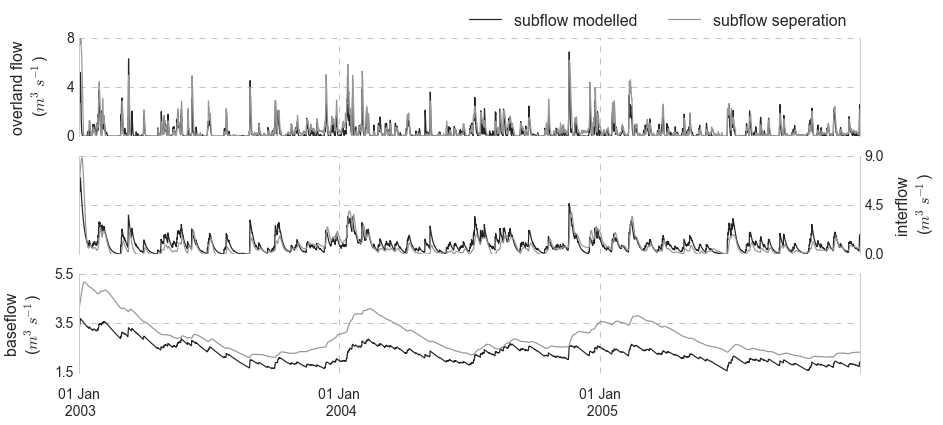

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
fig.subplots_adjust(hspace = 0.2)

#first plot
axs[0].plot(data2plot.index, data2plot['modover'], label='subflow modelled')
axs[0].plot(subflow2plot.index, subflow2plot['overland flow'].values, label='subflow seperation')
axs[0].set_ylabel("overland flow \n ($m^3s^{-1}$)")
axs[0].yaxis.labelpad = 15

#second plot
axs[1].plot(data2plot.index, data2plot['modinter'])
axs[1].plot(subflow2plot.index, subflow2plot['interflow'].values)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel("interflow \n ($m^3s^{-1}$)")
axs[1].yaxis.labelpad = 15

# third plot
axs[2].plot(data2plot.index, data2plot['modbase'])
axs[2].plot(subflow2plot.index, subflow2plot['baseflow'].values)

axs[2].xaxis.set_major_locator(
                mpl.dates.MonthLocator(interval = 12))
axs[2].xaxis.set_major_formatter(
                mpl.dates.DateFormatter('%d %b \n %Y'))
axs[2].tick_params(axis = 'x', pad = 15, direction='out')
axs[2].set_ylabel("baseflow \n($m^3s^{-1}$)")
axs[2].yaxis.labelpad = 10

#editing of the style:
for ax in axs:

    # y-axis
    ax.tick_params(axis = 'y', pad = 5, direction='out')
    ax.yaxis.set_major_locator(LinearLocator(3))
    
    #remove spines
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # set grid
    ax.grid(which='both', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)
    # line colors of the plots
    ax.lines[0].set_color(setblue[0])
    ax.lines[1].set_color(setblue[2])
    
    # line widths
    for line in ax.lines:
        line.set_linewidth(1.2)
    # remove ticklabels if redundant
    if not ax.is_last_row():
        ax.set_xlabel('')
        plt.setp(axs[1].get_xminorticklabels(), visible=False)
        plt.setp(axs[1].get_xmajorticklabels(), visible=False)
        plt.setp(axs[1].get_xminorticklabels(), visible=False)  

temp = axs[0]
temp.legend(loc='upper right', fontsize=16, ncol=2, bbox_to_anchor=(1., 1.4))
fig.savefig('vhm_subflow_example.pdf')
fig.savefig('vhm_subflow_example.png')

### Plot fractions in time overview

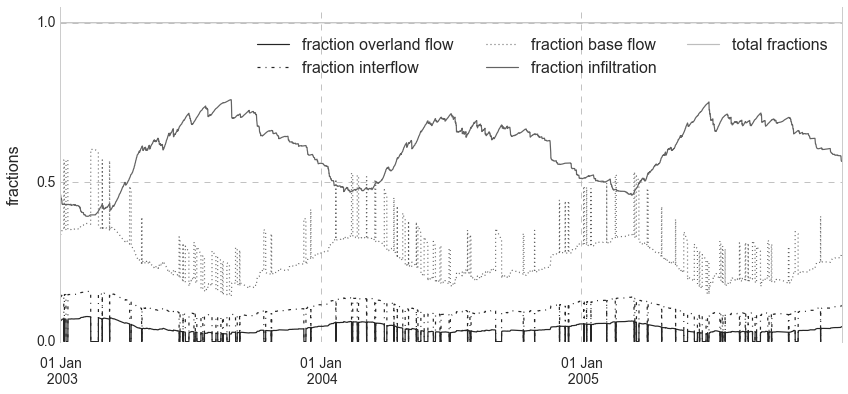

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(14, 6), sharex=True)

axs.plot(data2plot.index, data2plot['fracover'],'-', label='fraction overland flow')
axs.plot(data2plot.index, data2plot['fracinter'],'-.', label='fraction interflow')
axs.plot(data2plot.index, data2plot['fracbase'],':', label='fraction base flow')
axs.plot(data2plot.index, data2plot['fracsoil'],'-', label='fraction infiltration')
axs.plot(data2plot.index, data2plot['fractotal'],'-', label='total fractions')

axs.set_ylabel("fractions")
axs.yaxis.labelpad = 15

axs.xaxis.set_major_locator(
                mpl.dates.MonthLocator(interval = 12))
axs.xaxis.set_major_formatter(
                mpl.dates.DateFormatter('%d %b \n %Y'))
axs.tick_params(axis = 'x', pad = 15, direction='out')

# y-axis
axs.tick_params(axis = 'y', pad = 5, direction='out')
axs.yaxis.set_ticks([0,0.5,1.])
axs.set_ylim([0., 1.05])

#remove spines
axs.spines['bottom'].set_visible(False)
axs.spines['top'].set_visible(False)
# set grid
axs.grid(which='both', axis='both', color='0.7',
             linestyle='--', linewidth=0.8)
# line colors of the plots
axs.lines[0].set_color(setblue[0])
axs.lines[1].set_color(setblue[0])
axs.lines[2].set_color(setblue[1])
axs.lines[3].set_color(setblue[1])
axs.lines[4].set_color(setblue[3])

# line widths
for line in axs.lines:
    line.set_linewidth(1.2)

axs.legend(loc='upper right', fontsize=16, ncol=3, bbox_to_anchor=(1., 0.95))
#plt.savefig('vhm_fractions_example_noante.pdf', dpi=300)
#plt.savefig('vhm_fractions_example_noante.png', dpi=300)

### Soil moisture plot

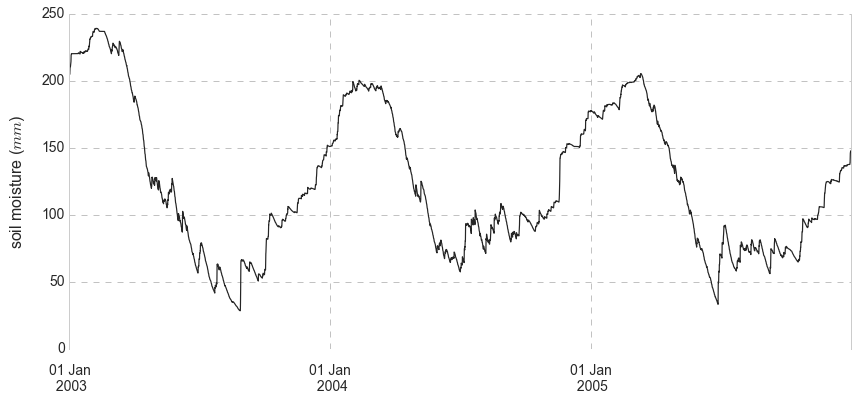

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(14, 6), sharex=True)

axs.plot(data2plot.index, data2plot['soil'],'-')

axs.set_ylabel(r"soil moisture ($mm$)")
axs.yaxis.labelpad = 15

axs.xaxis.set_major_locator(
                mpl.dates.MonthLocator(interval = 12))
axs.xaxis.set_major_formatter(
                mpl.dates.DateFormatter('%d %b \n %Y'))
axs.tick_params(axis = 'x', pad = 15, direction='out')

# y-axis
axs.tick_params(axis = 'y', pad = 5, direction='out')

#remove spines
axs.spines['bottom'].set_visible(False)
axs.spines['top'].set_visible(False)
# set grid
axs.grid(which='both', axis='both', color='0.7',
             linestyle='--', linewidth=0.8)
# line colors of the plots
axs.lines[0].set_color(setblue[0])

# line widths
for line in axs.lines:
    line.set_linewidth(1.2)

#plt.savefig('vhm_moisture_example.pdf', dpi=300)
#plt.savefig('vhm_moisture_example.png', dpi=300)